# 不同初始条件下重力摆问题

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline

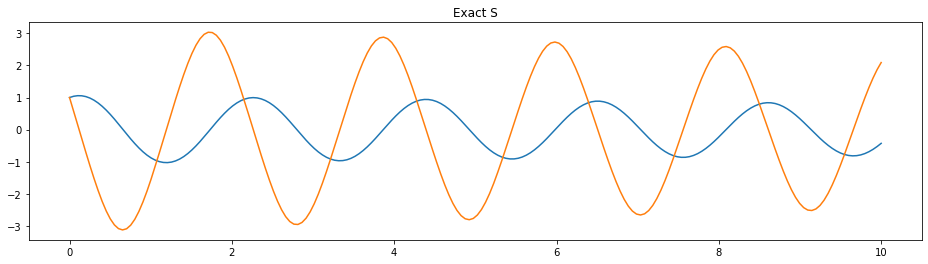

In [2]:
def Exact_f(U0, T):
    # 定义常微分方程的右侧函数
    def ode(t, y):
        s1, s2 = y
        ds1_dt = s2
        ds2_dt = -0.05 * s2 - 9.81 * np.sin(s1)
        return [ds1_dt, ds2_dt]
    if T == 0:
        return U0[0], U0[1]
    t_span = (0, T)
    sol = solve_ivp(ode, t_span, U0, t_eval=T)
    s1_T, s2_T = sol.y[:, -1]
    
    return s1_T, s2_T
U0 = [1.0, 1.0]
T = np.linspace(0,10,200).reshape(-1,1)
S1=[]
S2=[]
for i in range(len(T)):
    s1_T, s2_T = Exact_f(U0, T[i])
    S1.append(s1_T)
    S2.append(s2_T)
fig = plt.figure(figsize=(16, 4))
plt.plot(T,S1)
plt.plot(T,S2)
plt.title('Exact S')
plt.show()

In [3]:
# Data Generate
N_res = 2000
N_ics = 5000
T = 1

res_u = np.random.random((N_res,2)) * 6 - 3   # -3~3
res_y = np.random.random((N_res,1)) * T      # 0~T
res_s = np.array(list(map(Exact_f,res_u,res_y)))

Res_u = torch.tensor(res_u.reshape(-1,2), dtype=torch.float32, requires_grad=True)
Res_y = torch.tensor(res_y.reshape(-1,1), dtype=torch.float32, requires_grad=True)
Res_s = torch.tensor(res_s.reshape(-1,2), dtype=torch.float32, requires_grad=True)

ics_u = np.random.random((N_ics,2)) * 6 - 3   # -3~3
ics_y = np.zeros((N_ics,1))
ics_s = np.array(list(map(Exact_f,ics_u,ics_y)))

ics_u = np.vstack((ics_u, res_u))
ics_y = np.vstack((ics_y, res_y))
ics_s = np.vstack((ics_s, res_s))

index = np.arange(0, N_res + N_ics)
np.random.shuffle(index)
ics_u = ics_u[index, :]
ics_y = ics_y[index, :]
ics_s = ics_s[index, :]

Ics_u = torch.tensor(ics_u.reshape(-1,2), dtype=torch.float32, requires_grad=True)
Ics_y = torch.tensor(ics_y.reshape(-1,1), dtype=torch.float32, requires_grad=True)
Ics_s = torch.tensor(ics_s.reshape(-1,2), dtype=torch.float32, requires_grad=True)

In [4]:
class BranchNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(BranchNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, x):
        x=self.net(x)
        return x

class TrunkNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(TrunkNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, x):
        x=self.net(x)
        return x

class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_channle, output_dim):
        super(DeepONet, self).__init__()
        self.branch_net = BranchNetwork(branch_input_dim, hidden_channle, output_dim)
        self.trunk_net = TrunkNetwork(trunk_input_dim, hidden_channle, output_dim)

    def forward(self, branch_input, trunk_input):
        branch_output = self.branch_net(branch_input)
        trunk_output = self.trunk_net(trunk_input)

        B1 = branch_output[:,:100]
        B2 = branch_output[:,100:]

        T1 = trunk_output[:,:100]
        T2 = trunk_output[:,100:]
        s1 = torch.sum(B1 * T1,axis=1)
        s2 = torch.sum(B2 * T2,axis=1)
        return s1, s2
model = DeepONet(2, 1, 100, 200)

[Epoch 1/2000] [loss: 8.34519100189209]
[Epoch 101/2000] [loss: 0.6900168061256409]
[Epoch 201/2000] [loss: 0.384224534034729]
[Epoch 301/2000] [loss: 0.1190372109413147]
[Epoch 401/2000] [loss: 0.06416445225477219]
[Epoch 501/2000] [loss: 0.058709725737571716]
[Epoch 601/2000] [loss: 0.05308239907026291]
[Epoch 701/2000] [loss: 0.04767601564526558]
[Epoch 801/2000] [loss: 0.04280656576156616]
[Epoch 901/2000] [loss: 0.042339812964200974]
[Epoch 1001/2000] [loss: 0.041844382882118225]
[Epoch 1101/2000] [loss: 0.041321657598018646]
[Epoch 1201/2000] [loss: 0.04077330604195595]
[Epoch 1301/2000] [loss: 0.04071533679962158]
[Epoch 1401/2000] [loss: 0.04065347835421562]
[Epoch 1501/2000] [loss: 0.04058760404586792]
[Epoch 1601/2000] [loss: 0.04051758348941803]
[Epoch 1701/2000] [loss: 0.040510524064302444]
[Epoch 1801/2000] [loss: 0.04050298407673836]
[Epoch 1901/2000] [loss: 0.04049491137266159]


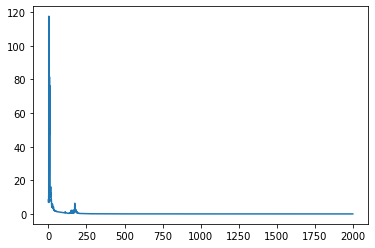

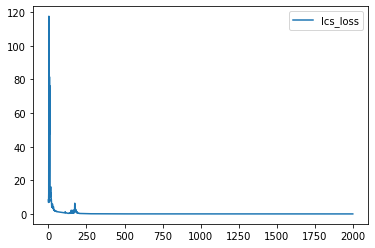

In [5]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)
epochs = 2000
Losses = []
Ics_loss = []
Res_loss = []

for epoch in range(epochs):
    optimizer.zero_grad()
    
    s1 = Ics_s[:, 0]
    s2 = Ics_s[:, 1]
    
    s1_pred, s2_pred = model(Ics_u, Ics_y)
    
    loss_s1 = torch.mean((s1.reshape(-1,1) - s1_pred.reshape(-1,1)) ** 2)
    loss_s2 = torch.mean((s2.reshape(-1,1) - s2_pred.reshape(-1,1)) ** 2)
    ics_loss = loss_s1 + loss_s2
    
    # s1_y = torch.autograd.grad(s1_pred, Res_y, torch.ones_like(s1_pred), retain_graph=True, create_graph=True)[0]
    # s2_y = torch.autograd.grad(s2_pred, Res_y, torch.ones_like(s2_pred), retain_graph=True, create_graph=True)[0]
    # res_1 = s1_y - s2_pred
    # res_2 = s2_y + 0.05 * s2_pred + 9.81 * torch.sin(s1_pred)
    
    # loss_res1 = torch.mean((res_1) ** 2)
    # loss_res2 = torch.mean((res_2) ** 2)
    # res_loss = loss_res1 + loss_res2
    
    loss = ics_loss #  + res_loss
    loss.backward()
    
    if epoch % 100 ==0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    Losses.append(loss.item())
    # Res_loss.append(res_loss.item())
    Ics_loss.append(ics_loss.item())
    optimizer.step()
    scheduler.step()
plt.plot(Losses)
plt.show()
# plt.plot(Res_loss, label='Res_loss')
plt.plot(Ics_loss, label='Ics_loss')
plt.legend()
plt.show()

In [6]:
def Get_pre(u0, Exact_u0, dT = 1):
    Ny = 200
    y_test = np.linspace(0, dT, Ny).reshape(-1,1)
    u0_star = np.tile(Exact_u0, (Ny, 1))
    s_exact = np.array(list(map(Exact_f,u0_star,y_test)))
    u_test = torch.tensor(u0_star, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    s1_pre, s2_pre = model(u_test, y_test)
    s1_pre = s1_pre.detach().numpy()
    s2_pre = s2_pre.detach().numpy()
    return y_test, s_exact, s1_pre.reshape(-1,1), s2_pre.reshape(-1,1)
u0 = np.array([1.0, 1.0])
y_test, s_exact, s1_pre, s2_pre= Get_pre(u0, u0)

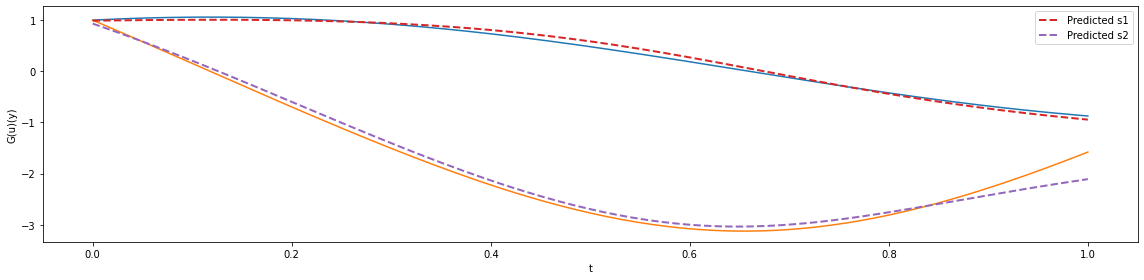

In [7]:
fig = plt.figure(figsize=(16, 4))
plt.plot(y_test, s_exact[:, 0], color='C0')
plt.plot(y_test, s_exact[:, 1], color='C1')
plt.plot(y_test, s1_pre, '--', label='Predicted s1', lw=2, color='C3')
plt.plot(y_test, s2_pre, '--', label='Predicted s2', lw=2, color='C4')
plt.xlabel('y')
plt.ylabel('G(u)(y)')
plt.xlabel('t')
plt.tight_layout()
plt.legend()
plt.show()

In [17]:
u0 = np.array([1.0, 1.0])
Exact_u0 = u0
T = 100
Y_test = np.linspace(0,T,200*T)
S_exact = np.array([])
S1_pre = np.array([])
S2_pre = np.array([])
for i in range(T):
    _, s_exact, s1_pre, s2_pre = Get_pre(u0, Exact_u0)
    if i==0:
        S_exact=s_exact
        S1_pre=s1_pre
        S2_pre=s2_pre
    else:
        S_exact=np.vstack((S_exact,s_exact))
        S1_pre=np.vstack((S1_pre,s1_pre))
        S2_pre=np.vstack((S2_pre,s2_pre))
    u0 = np.array([s1_pre[-1],s2_pre[-1]]).reshape(1,2)
    Exact_u0 = np.array(s_exact[-1]).reshape(1,2)
error = np.mean((S_exact[:, 0].reshape(-1,1)-S1_pre)**2) + np.mean((S_exact[:, 1].reshape(-1,1)-S2_pre)**2)
print(f'Time: 0 - {T}  Total Error: {error}')

Time: [0 - 100] Total Error: 0.02334605618213144


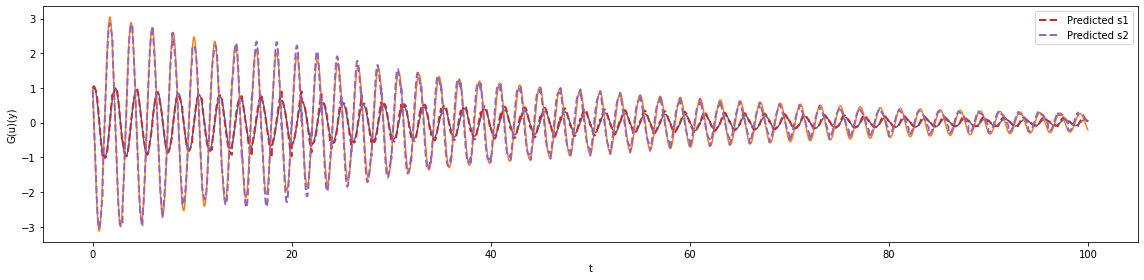

In [11]:
fig = plt.figure(figsize=(16, 4))
plt.plot(Y_test, S_exact[:, 0], color='C0')
plt.plot(Y_test, S_exact[:, 1], color='C1')
plt.plot(Y_test, S1_pre, '--', label='Predicted s1', lw=2, color='C3')
plt.plot(Y_test, S2_pre, '--', label='Predicted s2', lw=2, color='C4')
plt.xlabel('y')
plt.ylabel('G(u)(y)')
plt.xlabel('t')
plt.tight_layout()
plt.legend()
plt.show()

# 不同外力条件下重力摆问题

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import threading
%matplotlib inline

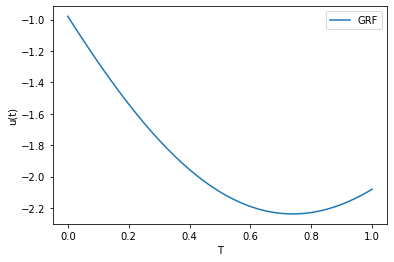

In [2]:
# 高斯过程随机信号采样 采样区间0-T，采样密度num=100
def GRF_Sample(T, num = 100):
    # 定义协方差函数
    def kernel(t1, t2, sigma_f=1.0, l=1.0):
        return sigma_f**2 * np.exp(-0.5 * (t1 - t2)**2 / l**2)

    # 生成时间点
    t = np.linspace(0, T, num)
    K = np.zeros((len(t), len(t)))

    # 计算协方差矩阵
    for i in range(len(t)):
        for j in range(len(t)):
            K[i, j] = kernel(t[i], t[j])

    # 采样高斯过程
    mean = np.zeros(len(t))
    u_samples = np.random.multivariate_normal(mean, K)
    
    return u_samples
u_samples = GRF_Sample(1,100)

tt = np.linspace(0, 1, 100)
plt.plot(tt, u_samples, label='GRF')
plt.xlabel('T')
plt.ylabel('u(t)')
plt.legend()
plt.show()

In [3]:
num_threads = 10
results = []
sample_num = 0
def worker(T, Nx, iterations):
    for _ in range(iterations):
        result = GRF_Sample(T, Nx)
        results.append(result)
        global sample_num
        sample_num += 1
        if sample_num % 10 == 0:
            print(f'Success *{sample_num}')
def run_multithreaded_grf(T, Nx, Nu):
    # 创建一个列表用于存储结果
    threads = []
    iterations_per_thread = Nu // num_threads
    print(f'Iterations/Thread: {iterations_per_thread}')
    for i in range(num_threads):
        thread = threading.Thread(target=worker, args=(T, Nx, iterations_per_thread))
        threads.append(thread)
        thread.start()
        print(i+1)
    for i, thread in enumerate(threads): # 等待所有线程完成
        thread.join()

    return results

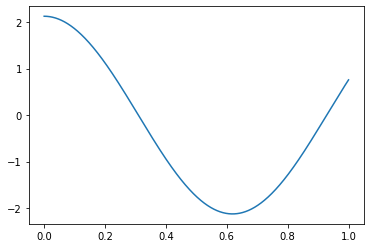

torch.Size([10000, 1000])


In [5]:
T = 1
Nu = 5000
Nx = 1000

#file = open(r'C:\Users\Fan\JupyterFile\DeepLearning\PINNs\pendulum_data\pendulum.csv')
#u_train1 = np.array(pd.read_csv(file, header=None))
#file.close()
#
#if Nu != 0:
#    u_train = np.array(run_multithreaded_grf(T, Nx, Nu))
#    u_train = np.vstack((u_train1,u_train))
#    file = r'C:\Users\Fan\JupyterFile\DeepLearning\PINNs\pendulum_data\pendulum.csv'
#    np.savetxt(file, u_train, delimiter=',')
#else:
#    u_train = u_train1
#
def generate_triangle(Nx):
    function_values = torch.zeros(Nx)
    num_terms = np.random.randint(1, 3)
    for _ in range(num_terms):
        frequency = np.random.uniform(0, 1)  # 频率
        amplitude = np.random.uniform(-1, 1)  # 幅度
        # 随机选择正弦或余弦
        if np.random.rand() > 0.5:
            function_values += amplitude * torch.sin(2 * np.pi * frequency * x)
        else:
            function_values += amplitude * torch.cos(2 * np.pi * frequency * x)
    
    return function_values.view(Nx,1)
x = torch.linspace(0, T, Nx)
u = generate_triangle(Nx)
plt.plot(x.numpy(), u.numpy())
plt.show()
con_u = []

for i in range(Nu):
    u = generate_triangle(Nx)
    con_u.append(u.squeeze(1))
u_train = torch.stack(con_u)
print(u_train.shape)

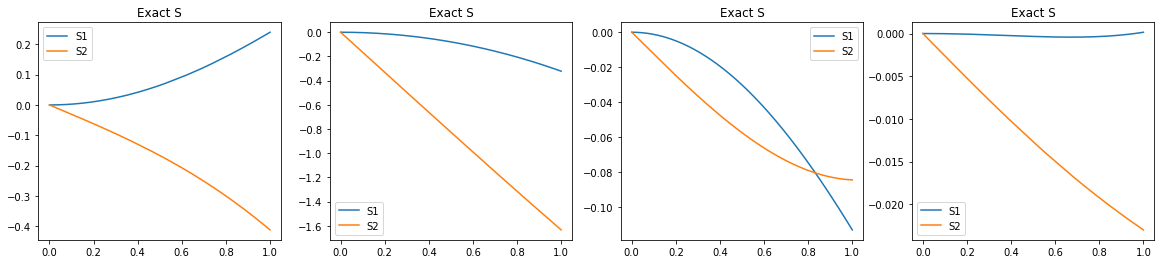

In [6]:
def Exact_f(T, u, U0 = [0.0, 0.0]):    # [num,num], num, [Nx,]
    # 定义常微分方程的右侧函数
    def ode(t, y):
        u_value = np.interp(t, np.linspace(0,T,Nx).flatten(), u).flatten()
        s1, s2 = y
        ds1_dt = s2
        ds2_dt = -1 * np.sin(s1) + u_value
        return [ds1_dt, ds2_dt]
    if T == 0:
        return U0[0], U0[1]
    t_span = (0, T)
    sol = solve_ivp(ode, t_span, U0, t_eval=T)
    s1_T, s2_T = sol.y[:, -1]
    
    return s1_T, s2_T
t = np.linspace(0,T,Nx).reshape(-1,1)
Exact_S1 = []
Exact_S2 = []
for j in range(4):
    S1=[]
    S2=[]
    for i in range(len(t)):
        s1_T, s2_T = Exact_f(t[i], u_train[j])
        S1.append(s1_T)
        S2.append(s2_T)
    Exact_S1.append(S1)
    Exact_S2.append(S2)
Exact_S1 = np.array(Exact_S1)
Exact_S2 = np.array(Exact_S2)
fig = plt.figure(figsize=(20, 4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(t,Exact_S1[i,:],label='S1')
    plt.plot(t,Exact_S2[i,:],label='S2')
    plt.title('Exact S')
    plt.legend()
plt.show()

In [7]:
class BranchNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(BranchNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, x):
        x=self.net(x)
        return x

class TrunkNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(TrunkNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, x):
        x=self.net(x)
        return x

class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_channle, output_dim):
        super(DeepONet, self).__init__()
        self.branch_net = BranchNetwork(branch_input_dim, hidden_channle, output_dim)
        self.trunk_net = TrunkNetwork(trunk_input_dim, hidden_channle, output_dim)

    def forward(self, branch_input, trunk_input):
        branch_output = self.branch_net(branch_input)
        trunk_output = self.trunk_net(trunk_input)

        B1 = branch_output[:,:100]
        B2 = branch_output[:,100:]

        T1 = trunk_output[:,:100]
        T2 = trunk_output[:,100:]
        s1 = torch.sum(B1 * T1,axis=1)
        s2 = torch.sum(B2 * T2,axis=1)
        return s1, s2

In [8]:
class ModifiedBranchNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(ModifiedBranchNetwork, self).__init__()
        self.activation = nn.Tanh()
        self.encodeU = nn.Linear(input_dim, hidden_channle)
        self.encodeV = nn.Linear(input_dim, hidden_channle)
        self.IN = nn.Linear(input_dim, hidden_channle)
        
        self.weight1 = nn.Linear(hidden_channle, hidden_channle)
        self.weight2 = nn.Linear(hidden_channle, hidden_channle)
        self.weight3 = nn.Linear(hidden_channle, hidden_channle)
        self.weight4 = nn.Linear(hidden_channle, hidden_channle)
            
        self.out = nn.Linear(hidden_channle, output_dim)
    def forward(self, x):
        U = self.activation(self.encodeU(x))
        V = self.activation(self.encodeV(x))
        H1 = self.activation(self.IN(x))
        
        Z1 = self.activation(self.weight1(H1))
        H2 = (1 - Z1) * U + Z1 * V
        
        Z2 = self.activation(self.weight2(H2))
        H3 = (1 - Z2) * U + Z2 * V
        
        Z3 = self.activation(self.weight3(H3))
        H4 = (1 - Z3) * U + Z3 * V
        
        Z4 = self.activation(self.weight4(H4))
        H5 = (1 - Z4) * U + Z4 * V
        
        x = self.out(H5)
        return x

class ModifiedTrunkNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(ModifiedTrunkNetwork, self).__init__()
        self.activation = nn.Tanh()
        self.encodeU = nn.Linear(input_dim, hidden_channle)
        self.encodeV = nn.Linear(input_dim, hidden_channle)
        self.IN = nn.Linear(input_dim, hidden_channle)
        
        self.weight1 = nn.Linear(hidden_channle, hidden_channle)
        self.weight2 = nn.Linear(hidden_channle, hidden_channle)
        self.weight3 = nn.Linear(hidden_channle, hidden_channle)
        self.weight4 = nn.Linear(hidden_channle, hidden_channle)
            
        self.out = nn.Linear(hidden_channle, output_dim)
    def forward(self, x):
        U = self.activation(self.encodeU(x))
        V = self.activation(self.encodeV(x))
        H1 = self.activation(self.IN(x))
        
        Z1 = self.activation(self.weight1(H1))
        H2 = (1 - Z1) * U + Z1 * V
        
        Z2 = self.activation(self.weight2(H2))
        H3 = (1 - Z2) * U + Z2 * V
        
        Z3 = self.activation(self.weight3(H3))
        H4 = (1 - Z3) * U + Z3 * V
        
        Z4 = self.activation(self.weight4(H4))
        H5 = (1 - Z4) * U + Z4 * V
        
        x = self.out(H5)
        return x

class ModifiedDeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_channle, output_dim):
        super(ModifiedDeepONet, self).__init__()
        self.branch_net = ModifiedBranchNetwork(branch_input_dim, hidden_channle, output_dim)
        self.trunk_net = ModifiedTrunkNetwork(trunk_input_dim, hidden_channle, output_dim)

    def forward(self, branch_input, trunk_input):
        branch_output = self.branch_net(branch_input)
        trunk_output = self.trunk_net(trunk_input)

        B1 = branch_output[:,:100]
        B2 = branch_output[:,100:]

        T1 = trunk_output[:,:100]
        T2 = trunk_output[:,100:]
        s1 = torch.sum(B1 * T1,axis=1)
        s2 = torch.sum(B2 * T2,axis=1)
        return s1, s2

In [9]:
model = ModifiedDeepONet(Nx, 1, 100, 200)
u = torch.tensor(u_train.numpy().reshape(-1,Nx), dtype=torch.float32, requires_grad=True)
y_train = np.random.random((u.shape[0],1)) * T      # 0~T
y = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32, requires_grad=True)
s_train = np.array(list(map(Exact_f, y_train, u_train)))
s = torch.tensor(s_train.reshape(-1,2), dtype=torch.float32, requires_grad=True)

[Epoch 1/2000] [loss: 3.5184264183044434]
[Epoch 101/2000] [loss: 0.08029518276453018]
[Epoch 201/2000] [loss: 0.0681263729929924]
[Epoch 301/2000] [loss: 0.06338818371295929]
[Epoch 401/2000] [loss: 0.05961988866329193]
[Epoch 501/2000] [loss: 0.05922562628984451]
[Epoch 601/2000] [loss: 0.058784715831279755]
[Epoch 701/2000] [loss: 0.058300092816352844]
[Epoch 801/2000] [loss: 0.05777048319578171]
[Epoch 901/2000] [loss: 0.0577128529548645]
[Epoch 1001/2000] [loss: 0.05765025317668915]
[Epoch 1101/2000] [loss: 0.05758265405893326]
[Epoch 1201/2000] [loss: 0.05750998109579086]
[Epoch 1301/2000] [loss: 0.05750223994255066]
[Epoch 1401/2000] [loss: 0.05749395117163658]
[Epoch 1501/2000] [loss: 0.05748509615659714]
[Epoch 1601/2000] [loss: 0.05747563764452934]
[Epoch 1701/2000] [loss: 0.05747485160827637]
[Epoch 1801/2000] [loss: 0.05747401341795921]
[Epoch 1901/2000] [loss: 0.05747310072183609]


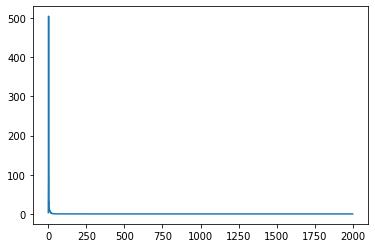

In [10]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)
epochs = 2000
Losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    
    s1 = s[:, 0]
    s2 = s[:, 1]
    
    s1_pred, s2_pred = model(u, y)
    
    loss_s1 = torch.mean((s1.reshape(-1,1) - s1_pred.reshape(-1,1)) ** 2)
    loss_s2 = torch.mean((s2.reshape(-1,1) - s2_pred.reshape(-1,1)) ** 2)
    loss = loss_s1 + loss_s2

    loss.backward()
    
    if epoch % 100 ==0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    Losses.append(loss.item())
    optimizer.step()
    scheduler.step()
plt.plot(Losses)
plt.show()

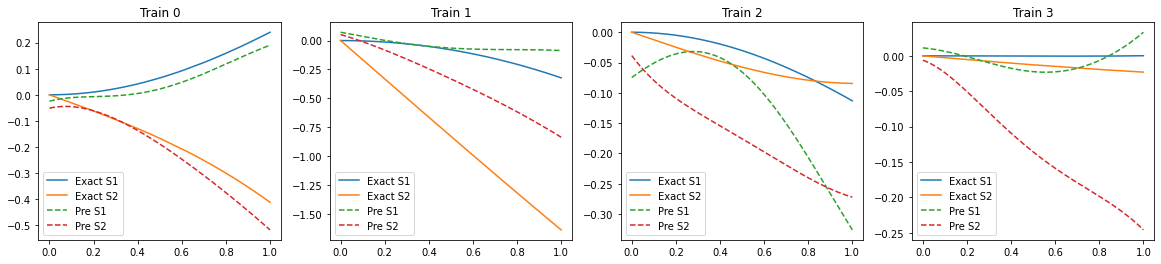

In [11]:
# 训练集展示
y_test = torch.tensor(t.reshape(-1,1), dtype=torch.float32, requires_grad=True)

fig = plt.figure(figsize=(20, 4))
for i in range(4):
    S1_pred, S2_pred = model(u[i,:].reshape(-1,Nx), y_test)
    S1 = S1_pred.detach().numpy()
    S2 = S2_pred.detach().numpy()
    plt.subplot(1,4,i+1)
    plt.plot(t,Exact_S1[i,:],label='Exact S1')
    plt.plot(t,Exact_S2[i,:],label='Exact S2')
    plt.plot(t,S1,label='Pre S1', linestyle='--')
    plt.plot(t,S2,label='Pre S2', linestyle='--')
    plt.title(f'Train {i}')
    plt.legend()
plt.show()

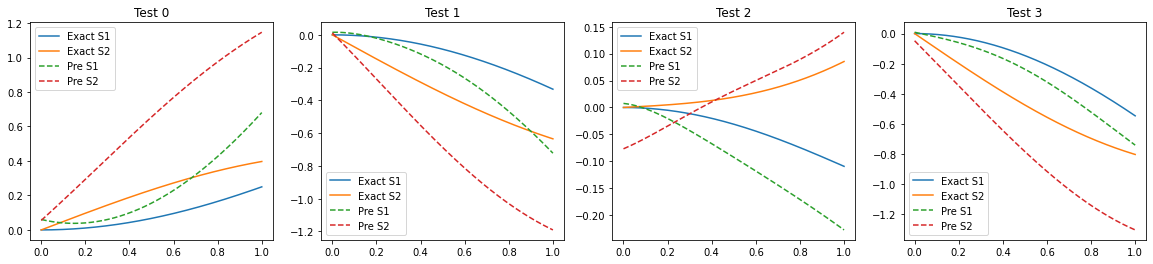

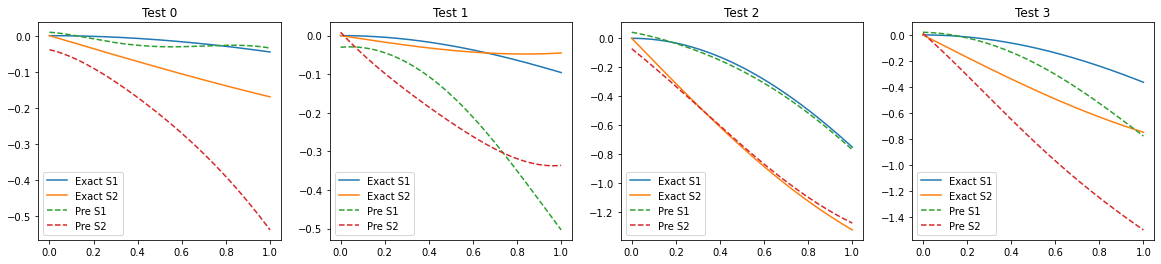

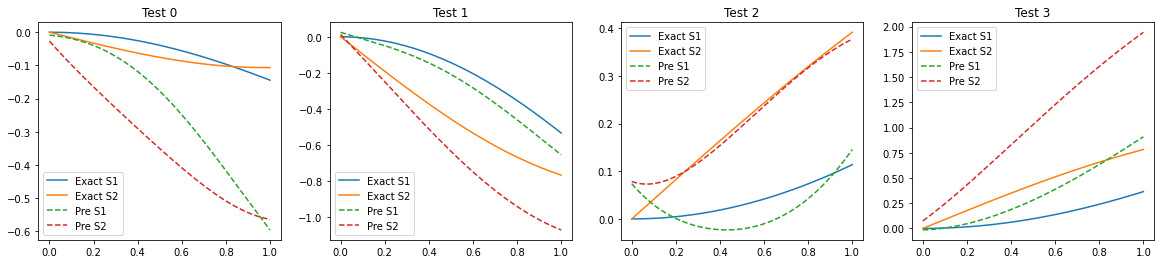

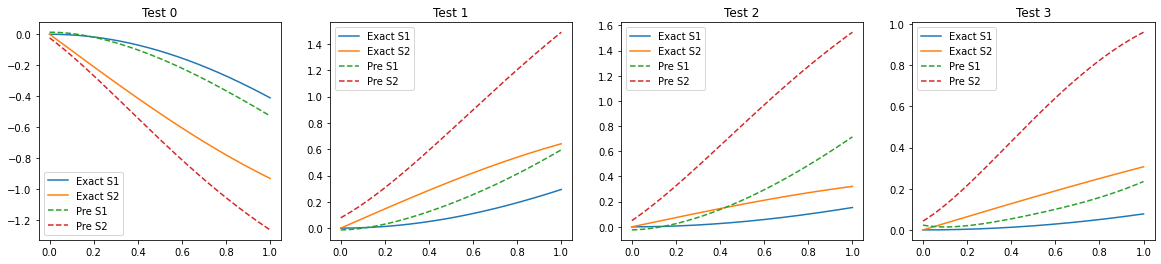

In [12]:
# 随机测试集演示
def Test():
    u_test = []
    for i in range(4):
        u_samples = GRF_Sample(T,Nx)
        u_test.append(u_samples)
    u_test = np.array(u_test)
    Exact_S1 = []
    Exact_S2 = []
    for j in range(4):
        S1=[]
        S2=[]
        for i in range(len(t)):
            s1_T, s2_T = Exact_f(t[i], u_test[j])
            S1.append(s1_T)
            S2.append(s2_T)
        Exact_S1.append(S1)
        Exact_S2.append(S2)
    Exact_S1 = np.array(Exact_S1)
    Exact_S2 = np.array(Exact_S2)
    y_test = torch.tensor(t.reshape(-1,1), dtype=torch.float32, requires_grad=True)
    u_test = torch.tensor(u_test.reshape(-1,Nx), dtype=torch.float32, requires_grad=True)
    fig = plt.figure(figsize=(20, 4))
    for i in range(4):
        S1_pred, S2_pred = model(u_test[i,:].reshape(-1,Nx), y_test)
        S1 = S1_pred.detach().numpy()
        S2 = S2_pred.detach().numpy()
        plt.subplot(1,4,i+1)
        plt.plot(t,Exact_S1[i,:],label='Exact S1')
        plt.plot(t,Exact_S2[i,:],label='Exact S2')
        plt.plot(t,S1,label='Pre S1', linestyle='--')
        plt.plot(t,S2,label='Pre S2', linestyle='--')
        plt.title(f'Test {i}')
        plt.legend()
    plt.show()
for i in range(4):
    Test()